In [1]:
import numpy as np                                      #import required libraries 
from matplotlib import *
from math import *
from sympy import *
import matplotlib.pyplot as plt

In [2]:
class NACAXXXX:                                          # class for NACA airfoil to get x and y coordinates of airfoil
    
    def __init__(self, digits, c):
        self.digits = str(digits)
        self.c = c                                                                 # replace x by x/c for scaling to the chord length
        self.m = float(self.digits[0])*(.01)*c                                       # max camber, m = (first digit from left)* (c/100)
        self.p = float(self.digits[1])*(.1)*c                                        # pos_max camber, p = (2nd digit from left)* (c/10)
        self.tmax = float(self.digits[2:])*(.01)*c                                   # max thickness, tmax = (last two digit)* (c/100)
        
    def camber(self, x):
        m = self.m
        p = self.p
        c = self.c

        if p == 0:
            yc = m*(c-x)*(1 + x/c - 2*p)/((1-p)**2)
        
        else:

            if 0 < x <= p*c :
                yc = (m/(p*p))*(2*p*x - x*x/c)
                
            else:
                yc = m*(c-x)*(1 + x/c - 2*p)/((1-p)**2)
            
        print("camber z coordinates: ", yc)
        return yc
            
    def thickness(self, x):
        tmax = self.tmax
        c = self.c
        #yt = ((tmax*c)/0.2)*(0.2969*sqrt(x/c) - 0.1260*(x/c) - 0.3516*pow(x/c, 2) + 0.2843*pow(x/c, 3) - 0.1015*pow(x/c, 4))
        yt = (5*tmax*c)*(0.2969*(x/c)**0.5-0.126*(x/c)-0.3516*(x/c)**2+0.2843*(x/c)**3-0.1036*(x/c)**4)
        print("thickness-camber to boundary length: ", yt)
        return yt
        
    def ftheta(self, x):
        m = self.m
        p = self.p
        c = self.c

        if p == 0:
            if x < 1e-6:
                theta1 = 0
            else:
                z = symbols('z')
                yc = m*(c-z)*(1 + z/c - 2*p)/((1-p*p)**2)
                yc_ = lambdify(z, yc, "numpy")
                value = yc_(x)
                #yc_ = diff(yc, z)
                #value = yc_.subs(z,x)
                theta1 = np.arctan2(value, 1)

        else:
            if 0 <= x <= p:
                z = symbols('z')
                yc = (m*z/(p*p))*(2*p - z/c)
                #yc_ = diff(yc, z)
                yc_ = lambdify(z, yc, "numpy")
                value = yc_(x)
                #value = yc_.subs(z,x)
                theta1 = np.arctan2(value, 1)

            elif p < x <= c:
                z = symbols('z')
                yc = m*(c-z)*(1 + z/c - 2*p)/((1-p*p)**2)
                yc_ = lambdify(z, yc, "numpy")
                value = yc_(x)
                #yc_ = diff(yc, z)
                #value = yc_.subs(z,x)
                theta1 = np.arctan2(value, 1)
        
        #print("theta1 is: ", theta1)
        return theta1      

    
    def get_Xu(self, x):
        self.Xu = x - self.thickness(x) * np.sin(self.ftheta(x))
        return self.Xu
    
    def get_Zu(self, x):
        #self.Zu = self.camber(x) + self.thickness(x) * np.cos(self.ftheta(x))
        self.Zu = self.camber(x) + self.thickness(x)
        print("value of Zu is: ", self.Zu)
        return self.Zu
    
    def get_Xl(self, x):
        self.Xl = x + self.thickness(x) * np.sin(self.ftheta(x))
        return self.Xl
    
    def get_Zl(self, x):
        #self.Zl = self.camber(x) - self.thickness(x) * np.cos(self.ftheta(x))
        self.Zl = self.camber(x) - self.thickness(x) 
        print("value of Zl is: ", self.Zl)
        return self.Zl



In [3]:
class linear_vortex_panel_method:
    
    def __init__(self, m, alpha, c, Zu, Zl):
        self.m = m                                      # m = no of panels, resulting into m+1 nodes
        self.alpha = alpha                              # alpha = angle of attack of airfoil
        self.c = c                                      # c = camber length
        self.Zu = Zu                                    # Zu = Z coordinates of upper part of airfoil
        self.Zl = Zl                                    # Zl = Z coordinates of lower part of airfoil
        
        self.X_j = np.zeros(m+1)                                 # X_j = X coordinates of jth node
        self.Z_j = np.zeros(m+1)                                 # Z_j = Z coordinates of jth node
        self.node_coordinates()
        
        self.X__i = np.zeros(m)                                  # X__i = X coordinates of control point of ith panel
        self.Z__i = np.zeros(m)                                  # Z__i = Z coordinate of control point of ith panel
        self.control_coordinates()
        
        self.l__i = np.zeros(m)
        self.length__i = np.zeros(m)
        self.length_panel()
        
        self.theta__i = np.zeros(m)
        self.theta_panel()
        
        self.c_ij__n1=np.zeros((m,m))                                           
        self.c_ij__n2=np.zeros((m,m))                                           
        self.c_ij__t1=np.zeros((m,m))
        self.c_ij__t2=np.zeros((m,m))
        self.normal_tangential_influence_coefficients()
        
        
        self.matrix_W_ij = np.zeros((m+1, m+1))
        self.matrix_C_i = np.zeros(m+1)
        self.gamma = np.zeros(m+1)
        self.solution_Y()

        self.n__i=np.zeros((m,2))                                               #2-D, (m rows & 2 columns ) array of zeros for unit normals
        self.t__i=np.zeros((m,2))                                               #2-D, (m rows & 2 columns ) array of zeros for unit tangents
        self.normal_tangent_panel()
        
        
    def node_coordinates(self):                               # function to get coordinates of jth node
        m = self.m 
        c = self.c
        Zu = self.Zu
        Zl = self.Zl
        X_j = self.X_j
        Z_j = self.Z_j

        #theta = np.linspace(-1,1,m+1)*np.pi                       
 
        #lower_nodes=0                                                           #nodes of lower surfaces
        #for i in range(0,theta.size):
            #if theta[i]<=0:
                #lower_nodes+=1                                                  #determinig the number of lower nodes
    
        #X_j = 0.5*(1 - np.cos(theta))                                          #glauert form
 
        #for j in range(0,lower_nodes):
            #Z_j[j] = Zl(X_j[j])                                                #lower surface nodes
 
        #for j in range(lower_nodes,m+1): 
            #Z_j[j] = Zu(X_j[j])

        theta = np.linspace(2*np.pi, 0, m+1)

        for j in range(0, theta.size):

            X_j[j] = 0.5*c*(1+np.cos(theta[j]))         # m+1-j because X[j] is taken in anticlock direction

        for j in range(0, theta.size):

            if np.pi < theta[j] <= 2*np.pi:
                Z_j[j] = Zl(X_j[j])

            else:
                Z_j[j] = Zu(X_j[j])                                             #upper surface nodes

        self.X_j = X_j
        self.Z_j = Z_j
        
        print("division of circle: ", theta)
        print("X node coordinate is : ", self.X_j)
        print("Z node coordinate is : ", self.Z_j)

    def control_coordinates(self):                            # function to get coordinates of control point of ith panel
        m = self.m
        X_j = self.X_j
        Z_j = self.Z_j
        X__i = self.X__i
        Z__i = self.Z__i

        for i in range(0, m):
            X__i[i] = (X_j[i] + X_j[i+1])/2
            Z__i[i] = (Z_j[i] + Z_j[i+1])/2

        self.X__i = X__i
        self.Z__i = Z__i


    def length_panel(self):
        m = self.m
        length__i = self.length__i
        X_j = self.X_j
        Z_j = self.Z_j

        for i in range(0, m):
            length__i[i] = ((X_j[i+1]-X_j[i])**2 + (Z_j[i+1]-Z_j[i])**2)**0.5
            
        self.length__i = length__i
        print("length of panel: ", self.length__i)

    def theta_panel(self):
        m = self.m
        X_j = self.X_j
        Z_j = self.Z_j
        theta__i = self.theta__i

        for i in range(0, m):
            theta__i[i] = np.arctan2((Z_j[i+1]-Z_j[i]), (X_j[i+1]-X_j[i]))

        self.theta__i = theta__i
        print("theta_panel is : ", self.theta__i)

    def normal_tangent_panel(self):
        m=self.m
        theta__i=self.theta__i
        X_j=self.X_j
        Z_j=self.Z_j
        n__i=self.n__i
        t__i=self.t__i

        for i in range(0,m):                                                    #n=-sin(theta)i+cos(theta)k
            n__i[i][0]=-np.sin(theta__i[i])  
            n__i[i][1]=np.cos(theta__i[i])   
 
        for i in range(0,m):                                                    #t= cos(theta)i+sin(theta)k
            t__i[i][0]=np.cos(theta__i[i])
            t__i[i][1]=np.sin(theta__i[i])
        
        self.n__i=n__i
        self.t__i=t__i


    def normal_tangential_influence_coefficients(self):

        X_j = self.X_j
        Z_j = self.Z_j
        X__i = self.X__i
        Z__i = self.Z__i
        theta__i = self.theta__i
        length__i = self.length__i
        c_ij__n1 = self.c_ij__n1                                                  
        c_ij__n2 = self.c_ij__n2                                                  
        c_ij__t1 = self.c_ij__t1                                                  
        c_ij__t2 = self.c_ij__t2

        for i in range(0, m):
            for j in range(0, m):
                if i == j:
                    c_ij__n1[i][j] = -1
                    c_ij__n2[i][j] = 1
                    c_ij__t1[i][j] = np.pi/2
                    c_ij__t2[i][j] = np.pi/2
                else:
                    A = -((X__i[i]-X_j[j])*np.cos(theta__i[j])) - ((Z__i[i]-Z_j[j])*np.sin(theta__i[j]))
                    B = (X__i[i]-X_j[j])**2 + (Z__i[i]-Z_j[j])**2
                    C = np.sin(theta__i[i] - theta__i[j])
                    D = np.cos(theta__i[i] - theta__i[j])
                    E = ((X__i[i]-X_j[j])*np.sin(theta__i[j])) - ((Z__i[i]-Z_j[j])*np.cos(theta__i[j]))
                    F = np.log(1+((length__i[j]**2)+(2*length__i[j]*A))/B)
                    G = np.arctan2((E*length__i[j]), (B+A*length__i[j]))
                    P= (((X__i[i]-X_j[j])*(np.sin(theta__i[i]-2*theta__i[j])))+((Z__i[i]-Z_j[j])*(np.cos(theta__i[i]-2*theta__i[j]))))
                    Q= (((X__i[i]-X_j[j])*(np.cos(theta__i[i]-2*theta__i[j])))-((Z__i[i]-Z_j[j])*(np.sin(theta__i[i]-2*theta__i[j]))))

                    c_ij__n2[i][j]= D + 0.5*Q*F/(length__i[j]) - (A*C+D*E)*G/(length__i[j])   
                    c_ij__n1[i][j]= 0.5*D*F + C*G - c_ij__n2[i][j]              

                    c_ij__t2[i][j]= C + (0.5*P*F)/length__i[j] + (A*D-C*E)*G/length__i[j] 
                    c_ij__t1[i][j]= 0.5*C*F - D*G - c_ij__t2[i][j]
    
        print("value of coeff1:", c_ij__n1)
        print("value of coeff2:", c_ij__n2)

        self.c_ij__n1=c_ij__n1
        self.c_ij__n2=c_ij__n2
        self.c_ij__t1=c_ij__t1
        self.c_ij__t2=c_ij__t2



    def solution_Y(self):
        m = self.m
        alpha = self.alpha
        X__i = self.X__i
        Z__i = self.Z__i
        theta__i = self.theta__i
        length__i = self.length__i
        c_ij__n1 = self.c_ij__n1
        c_ij__n2 = self.c_ij__n2
        c_ij__t1 = self.c_ij__t1
        c_ij__t2 = self.c_ij__t2
        matrix_W_ij = self.matrix_W_ij
        matrix_C_i = self.matrix_C_i
        gamma = self.gamma



        # write matrix W and C using for loop, then solve for Y

        # writing C matrix using for loop

        for i in range(0, m):
            matrix_C_i[i] = np.sin(theta__i[i]-alpha)

        matrix_C_i[m] = 0
        print("jeeta matrix is: ", matrix_C_i)

        # writing W matrix using for loop

        for i in range(0, m):
            for j in range(1,m):
                matrix_W_ij[i][j] = c_ij__n2[i][j-1] + c_ij__n1[i][j]

            matrix_W_ij[i][0] = c_ij__n1[i][0]          # j = 0
            matrix_W_ij[i][m] = c_ij__n2[i][m-1]        # j = m

        #for j in range(1, m):
            #matrix_W_ij[m][j] = 0

        matrix_W_ij[m][0] = 1                           # i = m, j = 0
        matrix_W_ij[m][m] = 1                           # i = m, j = m

        print("W matrix is: ", matrix_W_ij)

        Y = np.linalg.solve(matrix_W_ij, matrix_C_i)
        print("gamma is: ", Y)
        gamma = Y

        self.matrix_W_ij = matrix_W_ij
        self.matrix_C_i = matrix_C_i
        self.gamma = gamma
        

    def get_Cp(self, alpha):
        m = self.m
        alpha = self.alpha
        theta__i = self.theta__i
        c_ij__t1 = self.c_ij__t1
        c_ij__t2 = self.c_ij__t2
        gamma = self.gamma


        velocity_ratio = np.zeros(m)

        for i in range(0, m):
            addn = 0
            for j in range(0, m):
                
                addn = addn + c_ij__t1[i][j]*gamma[j] + c_ij__t2[i][j]*gamma[j+1]
            velocity_ratio[i] = np.cos(theta__i[i] - alpha) + addn

        Cp__i = np.zeros(m)

        for i in range(0, m):
            Cp__i[i] = 1 -(velocity_ratio[i])**2
        
        self.Cp__i = Cp__i
        
        print("Cp values are: ", Cp__i)

    def get_Cl(self, alpha):
        m = self.m
        alpha = self.alpha
        theta__i = self.theta__i
        c_ij__t1 = self.c_ij__t1
        c_ij__t2 = self.c_ij__t2
        gamma = self.gamma
        n__i=self.n__i
        Cp__i = self.Cp__i
        length__i = self.length__i

        f_x = - np.sum(Cp__i*self.length__i*self.n__i[:,0])                         #Normal component force
        f_z = - np.sum(Cp__i*self.length__i*self.n__i[:,1])                         #Axial component of force
        c_l = f_z*np.cos(alpha) - f_x*np.sin(alpha)                               #lift

        sum=0
        for j in range(0,m):
            sum+=(gamma[j]+gamma[j+1])*length__i[j]                                  
 
        c_l=2*np.pi*sum

        self.c_l = c_l
        return c_l



In [4]:
class Hess_Smith_Method(linear_vortex_panel_method):

    def influence_coefficients(self):
        c_ij__n1 = self.c_ij__n1
        c_ij__n2 = self.c_ij__n2
        c_ij__t1 = self.c_ij__t1
        c_ij__t2 = self.c_ij__t2
        #lamda_ij__n = self.lamda_ij__n
        #lamda_ij__t = self.lamda_ij__t
        sigma_ij__n = np.zeros((m+1, m+1))
        sigma_ij__t = np.zeros((m+1, m+1))

        lamda_ij__n = c_ij__n1 + c_ij__n2
        lamda_ij__t = c_ij__t1 + c_ij__t2

        for i in range(0, m):
            for j in range(0, m):
                if i == j:
                    lamda_ij__n[i][j] = 0
                    lamda_ij__t[i][j] = np.pi
        
        sigma_ij__n = lamda_ij__t
        sigma_ij__t = -(lamda_ij__n)
        
        self.sigma_ij__n = sigma_ij__n
        self.sigma_ij__t = sigma_ij__t
        self.lamda_ij__n = lamda_ij__n
        self.lamda_ij__t = lamda_ij__t

    
    def strength__q(self):
        self.influence_coefficients()
        m = self.m 
        alpha = self.alpha
        theta__i = self.theta__i
        lamda_ij__n = self.lamda_ij__n
        lamda_ij__t = self.lamda_ij__t
        sigma_ij__n = self.sigma_ij__n
        sigma_ij__t = self.sigma_ij__t

        matrix_Z = np.zeros((m+1, m+1))
        matrix_X = np.zeros(m+1)

        #writing matrix X

        for i in range(0, m):
            matrix_X[i] = np.sin(theta__i[i] - alpha)
        
        matrix_X[m] = -(np.cos(theta__i[0] - alpha)) - (np.cos(theta__i[m-1] - alpha))

        for i in range(0, m):
            for j in range(0, m):
                matrix_Z[i][j] = sigma_ij__n[i][j]
                matrix_Z[i][m] += lamda_ij__n[i][j]

        for j in range(0, m):
            matrix_Z[m][j] = sigma_ij__t[0][j] + sigma_ij__t[m-1][j]
            matrix_Z[m][m] += (lamda_ij__t[0][j] + lamda_ij__t[m-1][j])

        eeta = np.linalg.solve(matrix_Z, matrix_X)

        self.eeta = eeta
        print("eeta matrix is: ", eeta)

        
    def get_Cp(self, alpha):
        m = self.m
        alpha = self.alpha
        theta__i = self.theta__i
        sigma_ij__t = self.sigma_ij__t
        lamda_ij__t = self.lamda_ij__t
        eeta = self.eeta


        velocity_ratio = np.zeros(m)

        for i in range(0, m):
            addn = 0
            for j in range(0, m):
                
                addn = addn + sigma_ij__t[i][j]*eeta[j] + lamda_ij__t[i][j]*eeta[m]
            velocity_ratio[i] = np.cos(theta__i[i] - alpha) + addn

        Cp__i = np.zeros(m)

        for i in range(0, m):
            Cp__i[i] = 1 -(velocity_ratio[i])**2
        
        self.Cp__i = Cp__i
        
        print("HS Cp values are: ", Cp__i)

    def get_Cl(self, alpha):
        m = self.m
        alpha = self.alpha
        theta__i = self.theta__i
        c_ij__t1 = self.c_ij__t1
        c_ij__t2 = self.c_ij__t2
        eeta = self.eeta
        n__i=self.n__i
        Cp__i = self.Cp__i
        length__i = self.length__i

        f_x = - np.sum(Cp__i*length__i*n__i[:,0])
        f_z = - np.sum(Cp__i*length__i*n__i[:,1])
        c_l = f_z*np.cos(alpha) - f_x*np.sin(alpha)                           #Lift=Ncos(a)-Asin(a) by Cp 
                               
        sum=0
        for j in range(0,m):
            sum+=2*(eeta[m])*length__i[j]
 
        c_l=2*np.pi*sum    
        return c_l                          
        


In [5]:
digits = (input("enter the four digits of NACAXXXX airfoil: "))
c = float(input("enter the chord length: "))
m = int(input("enter no of panels: "))
alpha = float(input("enter angle of attack of airfoil: "))

airfoil_1 = NACAXXXX(digits, c)
result_vm = linear_vortex_panel_method(m, alpha*(np.pi)/180, c, airfoil_1.get_Zu, airfoil_1.get_Zl)
result_vm.get_Cp(alpha)
result_hm = Hess_Smith_Method(m, alpha*(np.pi)/180, c, airfoil_1.get_Zu, airfoil_1.get_Zl)
result_hm.strength__q()
result_hm.get_Cp(alpha)


camber z coordinates:  0.0
thickness-camber to boundary length:  -4.718447854656916e-17
value of Zl is:  4.718447854656916e-17
camber z coordinates:  0.0002712896496020805
thickness-camber to boundary length:  0.004467979985585163
value of Zl is:  -0.004196690335983083
camber z coordinates:  0.0010514849517556622
thickness-camber to boundary length:  0.01731666290784444
value of Zl is:  -0.016265177956088776
camber z coordinates:  0.0022448090217288643
thickness-camber to boundary length:  0.037034346115738935
value of Zl is:  -0.03478953709401007
camber z coordinates:  0.0037082324375124908
thickness-camber to boundary length:  0.0615161848076046
value of Zl is:  -0.05780795237009211
camber z coordinates:  0.0052734374999999995
thickness-camber to boundary length:  0.08841243955211972
value of Zl is:  -0.08313900205211971
camber z coordinates:  0.006772219156006005
thickness-camber to boundary length:  0.11527752092232339
value of Zl is:  -0.10850530176631738
camber z coordinates:  0.

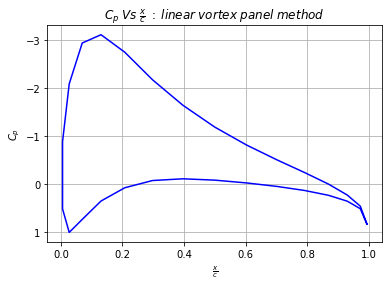

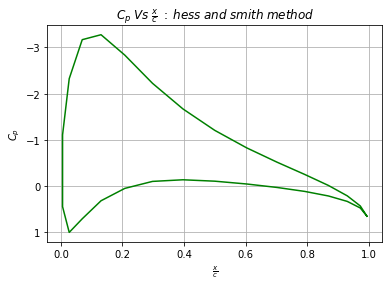

In [6]:
X__i = result_vm.X__i                                                                #similar & repeated plotting commands for representing  the results
Z__i= result_vm.Z__i
Cp__i_vm = result_vm.Cp__i
Cp__i_hm = result_hm.Cp__i
 
plt.figure(1)
plt.plot(X__i,Cp__i_vm,'b')
plt.gca().invert_yaxis()
plt.xlabel(r'$\frac{x}{c}$')
plt.ylabel(r'$C_p$')
plt.title(r'$C_p \; Vs \; \frac{x}{c}\; :\;linear\;vortex\;panel\;method$')
plt.grid(True)


plt.figure(2)
plt.plot(X__i,Cp__i_hm,'g')
plt.gca().invert_yaxis()
plt.xlabel(r'$\frac{x}{c}$')
plt.ylabel(r'$C_p$')
plt.title(r'$C_p \; Vs \; \frac{x}{c}\; :\;hess\;and\;smith\;method$')
plt.grid(True)

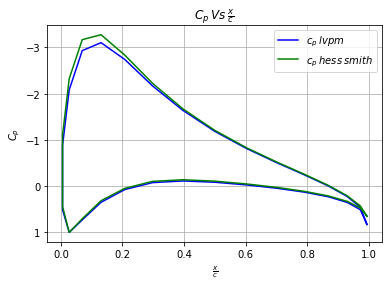

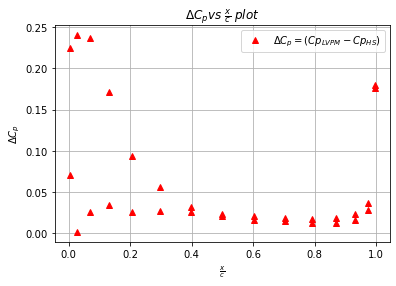

In [7]:
plt.figure(3)
plt.plot(X__i,Cp__i_vm,'b',X__i,Cp__i_hm,'g',)
plt.legend(["$c_{p}\:lvpm$","$c_{p}\:hess\:smith$"])
plt.gca().invert_yaxis()
plt.ylabel(r"$C_p$")
plt.xlabel(r"$\frac{x}{c}$")
plt.title(r"$C_p\:Vs\:\frac{x}{c}$")
plt.grid(True)
 
plt.figure(4)
plt.plot(X__i,(abs(Cp__i_vm-Cp__i_hm)),'r^')
plt.ylabel(r"$\Delta C_p$")
plt.xlabel(r"$\frac{x}{c}$")
plt.title(r"$\Delta C_p vs\ \frac{x}{c} \;plot$")
plt.legend([r"$\Delta C_p= (Cp_{LVPM}-Cp_{HS})$"])
plt.grid(True)

In [8]:
airfoils=np.array(["00","14","24","44"])                                        #array for first two digits
thickness=np.array(["06","08","10","12","14","16","18","20","22","24"])         #array for last two digits
c_l1=np.zeros((4,10,20))
c_l2=np.zeros((4,10,20))

alpha=np.linspace(-15,23,20)
def master(n):                                                                  #funtion to run the required claculations of Cl in loops for several airfoils as described in arrays
    for  i in range(0,4):
        digit=""
        for  j in range(0,10):
            digit=airfoils[i]
            digit=digit+thickness[j]                                            #concatenation of first two and last two digits

    
            airfoil=NACAXXXX(digit, c)                                             #Decoding the airfoil nomenclature

            pfoil1=linear_vortex_panel_method(m,alpha,c, airfoil.get_Zu,airfoil.get_Zl)                   #using LVPM class  
            pfoil2=Hess_Smith_Method(m,alpha, airfoil.get_Zu,airfoil.get_Zl)                        #using Hess smith class
            #print('>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Airfoil:',digit,'<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<')
            #print("---------------------------------------------LVPM--------------------------------------------------------------------------HS----------------------------")
            
            for  k in range(0,20):
           
                pq=pfoil1.get_Cl(alpha[k]*np.pi/180)               #result of LVPM class 
                c_l1[i][j][k]=pq
                pq1=pfoil2.get_Cl(alpha[k]*np.pi/180)               #result of Hess smith class
                c_l2[i][j][k]=pq1

                #print('AoA',alpha[k],'------------Cl:',c_lg1,'------------Cm',c_m1,'-----------Cl',c_lg2,'-----------Cm',c_m2)
master(160)

camber z coordinates:  0.0
thickness-camber to boundary length:  -8.326672684688674e-18
value of Zl is:  8.326672684688674e-18
camber z coordinates:  0.0
thickness-camber to boundary length:  0.0007884670562797346
value of Zl is:  -0.0007884670562797346
camber z coordinates:  0.0
thickness-camber to boundary length:  0.0030558816896196065
value of Zl is:  -0.0030558816896196065
camber z coordinates:  0.0
thickness-camber to boundary length:  0.006535472843953929
value of Zl is:  -0.006535472843953929
camber z coordinates:  0.0
thickness-camber to boundary length:  0.010855797318989046
value of Zl is:  -0.010855797318989046
camber z coordinates:  0.0
thickness-camber to boundary length:  0.015602195215079948
value of Zl is:  -0.015602195215079948
camber z coordinates:  0.0
thickness-camber to boundary length:  0.02034309192746883
value of Zl is:  -0.02034309192746883
camber z coordinates:  0.0
thickness-camber to boundary length:  0.02462032886478966
value of Zl is:  -0.0246203288647896

ValueError: setting an array element with a sequence.

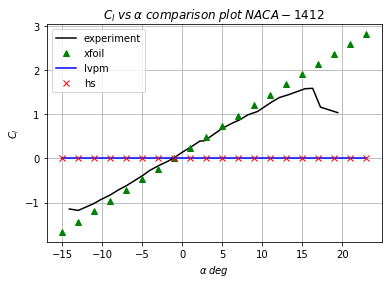

In [ ]:
#Comparing with experimental data
alpha=np.linspace(-15,23,20)
data1412=np.array([[19.426700 ,   1.04160000],[17.275600 ,   1.16678000],  [16.298400 ,   1.59387000],
  [15.363800  ,  1.58560000],  [13.230600  ,  1.44561000],  [12.132000 ,   1.38396000],  [11.192600   , 1.28391000],
  [ 9.409510  ,  1.06710000],   [8.213260  ,   .99207100],   [7.176200  ,   .87698400],  [ 6.302400  ,   .80693600],
   [5.039350  ,   .68850400],   [4.163470  ,   .57673000],   [2.800870  ,   .40155100],   [2.220010   ,  .39488200],
   [1.019990   ,  .25138800],  [  .144680   ,  .15627600],  [ -.958319  ,   .02111030],  [-1.768670  ,  -.06233150],
  [-2.967180  ,  -.16581000],  [-4.036770  ,  -.27096200],  [-4.913240  ,  -.38612600],  [-5.886350  ,  -.49629400],
  [-6.924440  ,  -.61481400],  [-7.994220  ,  -.71832500],  [-8.967510  ,  -.82851200], [-10.166700  ,  -.93538400],
 [-11.074900  , -1.02889000], [-12.954300  , -1.17922000], [-14.083500  , -1.14761000]])

data2412=np.array([[ 20.437000 ,   1.13378000],  [18.246800  ,  1.20896000],  [16.312200  ,  1.50956000],  [15.796700  ,  1.56509000],
  [15.281500  ,  1.59448000],  [14.220000  ,  1.52753000],  [12.064400  ,  1.39849000],  [10.004900  ,  1.24328000],
  [ 7.976970  ,  1.04388000],   [5.851670  ,   .85585500],  [ 3.757740  ,   .64812800],  [ 1.663040  ,  .45668300],
   [-.174796  ,   .24551800],  [-2.303350  ,   .04736980], [ -4.207400  ,  -.18035100],  [-6.434330  ,  -.37538700],
  [-8.436870  ,  -.60493700]])

data4412=np.array([[20.229500  ,  1.26552000],  [18.311000  ,  1.32971000],  [16.136700  ,  1.39720000],  [15.114200  ,  1.45971000],
  [14.059700  ,  1.51892000],  [13.324000  ,   1.53047000],  [11.817300  ,  1.43523000],  [ 9.733940  ,  1.32522000],
  [ 7.713040  ,  1.16753000],  [ 1.998180  ,   .60714800],  [-2.338590  ,   .16159900],  [-4.170820  ,  -.04726520],
  [-8.284480  ,  -.45685900]])

datax1412=np.array([[-15,	-1.6682],[-13	,-1.4327],[-11	,-1.1954],[-9	,-0.9567],[-7	,-0.7168],[-5,	-0.476],[-3,	-0.2347],
[-1,	0.0069],[1	,0.2485],[3	,0.4898],[5	,0.7305],[7	,0.9704],[9	,1.209],[11,	1.4462],[13,	1.6816],
[15,	1.915],[17,	2.146],[19,	2.3745],[21,	2.6],[23,	2.8224]])

datax2412=np.array([[-15,	-1.5448],[-13	,-1.3082],[-11	,-1.07],[-9	,-0.8306],[-7	,-0.5901],[-5,	-0.3488],[-3,	-0.1072],
[-1,	0.1345],[1,	0.3761],[3	,0.6173],[5	,0.8577],[7	,1.097],[9	,1.335],[11,	1.5714],[13,	1.8059],
[15,	2.0382],[17,	2.268],[19,	2.495],[21,	2.719],[23,	2.9398]])

datax4412=np.array([[-15	,-1.2988],[-13	,-1.0601],[-11,	-0.8201],[-9,	-0.5791],[-7,	-0.3374],[-5,	-0.0953],[-3,	0.1469],
[-1,	0.3889],[1	,0.6305],[3	,0.8712],[5,	1.111],[7,	1.3493],[9	,1.5861],[11,	1.8208],[13,	2.0534],[15,	2.2835],
[17,	2.5108],[19,	2.7351],[21,	2.956],[23,	3.1734]])
plt.figure(5)
plt.plot(data1412[:,0],data1412[:,1],'k-',datax1412[:,0],datax1412[:,1],'g^')
plt.plot(alpha,c_l1[1][3][:],'b')
plt.plot(alpha,c_l2[1][3][:],'rx')
plt.legend(['experiment','xfoil','lvpm','hs'])
plt.title(r'$C_l\;vs\;\alpha \;comparison\;plot \;NACA-1412$')
plt.xlabel(r'$\alpha\;deg$')
plt.ylabel(r'$C_l$')
plt.grid(True)

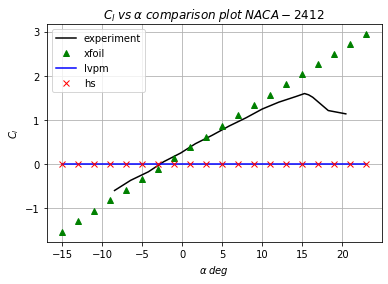

In [ ]:
plt.figure(6)
plt.plot(data2412[:,0],data2412[:,1],'k-',datax2412[:,0],datax2412[:,1],'g^')
plt.plot(alpha,c_l1[2][3][:],'b')
plt.plot(alpha,c_l2[2][3][:],'rx')
plt.legend(['experiment','xfoil','lvpm','hs'])
plt.title(r'$C_l\;vs\;\alpha \;comparison\;plot \;NACA-2412$')
plt.xlabel(r'$\alpha\;deg$')
plt.ylabel(r'$C_l$')
plt.grid(True)